In [ ]:
from skimage import io, feature, color, exposure, filters
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import pandas as pd
import numpy as np
import torch
import cv2

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import MiniBatchKMeans

In [ ]:
import matplotlib.pyplot as plt
import csv
import os
import tqdm

In [ ]:
data_split_dic = {i:{"train_range":(2*i*50,(2*i+1)*50-1),"test_range":((2*i+1)*50,(2*i+2)*50-1)} for i in range(20)}

def get_images(type="train"):
    images_dic = {"id":[], "data": [], "labels": []}
    for i in range(20):
        if type == "train":
            start, end = data_split_dic[i]["train_range"]
        else:
            start, end = data_split_dic[i]["test_range"]
        for j in range(start, end + 1):
            image = io.imread(f"data/origin/{j}.jpg")
            images_dic["id"].append(j)
            images_dic["data"].append(image)
            images_dic["labels"].append(i)
    return images_dic

train_data = get_images("train")
test_data = get_images("test")

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1) 
        self.bn1 = nn.BatchNorm2d(32) 
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 

        self.flatten = nn.Flatten()
        
        self.fc1_input_features = 64 * 24 * 24 
        self.fc1 = nn.Linear(self.fc1_input_features, 128) 
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.flatten(x)

        features = self.fc1(x)
        features = self.bn_fc1(features)
        features = self.relu3(features)
        return features
    
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images_data_list, labels_data_list, transform=None):
        self.images_data = images_data_list
        self.labels_data = labels_data_list
        self.transform = transform

    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, idx):
        image = self.images_data[idx]
        label = self.labels_data[idx]

        pil_image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(pil_image)
        else:
            image = transforms.ToTensor()(pil_image) 
            
        return image, torch.tensor(label, dtype=torch.long)
    
def train(model, train_dataset, val_dataset):
    lr = 0.001
    epochs = 20
    batch_size = 32
    weight_decay = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_val_loss = float('inf')

    model.to(device)
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm.tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_dataset)
        val_accuracy = correct / total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "model/best_model.pth")
            print("Best model saved.")

def test(model, test_dataset):
    batch_size = 32
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            predicted = torch.argmax(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.randn_like(x) * 0.05), 
    transforms.Lambda(lambda x: torch.clamp(x, 0., 1.))
])

train_images = train_data["data"]
train_labels = train_data["labels"]
test_images= test_data["data"]
test_labels = test_data["labels"]
#print(train_images)

train_dataset = ImageDataset(train_images, train_labels, transform=train_transform)
test_dataset = ImageDataset(test_images, test_labels, transform=train_transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

In [ ]:
cnn = CNN(num_classes=20).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
cnn.load_state_dict(torch.load("model/best_model.pth"))

#train(cnn, train_set, val_set)
test(cnn, test_dataset)

In [ ]:
def extract_graycomatrix_features(image):
    gray_image = color.rgb2gray(image)
    gray_image = (gray_image * 255).astype('uint8')
    distances = [1, 2, 3, 5]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    glcm = feature.graycomatrix(gray_image, distances, angles, symmetric=True, normed=True)

    entropy = feature.graycoprops(glcm, 'entropy')
    dissimilarity = feature.graycoprops(glcm, 'dissimilarity')
    energy = feature.graycoprops(glcm, 'energy')
    homogeneity = feature.graycoprops(glcm, 'homogeneity')
    contrast = feature.graycoprops(glcm, 'contrast')
    correlation = feature.graycoprops(glcm, 'correlation')

    features = torch.tensor([
        np.mean(contrast),
        np.mean(dissimilarity),
        np.mean(homogeneity),
        np.mean(energy),
        np.mean(correlation),
        np.mean(entropy)
    ], dtype=torch.float32)
    
    return features

In [ ]:
def extract_sift_descriptors(image):
    gray_image = color.rgb2gray(image)
    gray_image_uint8 = (gray_image * 255).astype('uint8')
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_image_uint8, None)
    return descriptors

def build_sift_vocabulary(data, vocabulary_size=200):
    descriptors_list = []

    for image in tqdm.tqdm(data["data"], desc="Extracting SIFT descriptors"):
        descriptors = extract_sift_descriptors(image)
        if descriptors is not None and len(descriptors) > 0:
            descriptors_list.append(descriptors)

    descriptors_np = np.vstack(descriptors_list)
    kmeans = MiniBatchKMeans(n_clusters=vocabulary_size, random_state=42, batch_size=vocabulary_size*5, n_init='auto')
    kmeans.fit(descriptors_np)
    return kmeans

def extract_sift_bow_features(image, kmeans_model, vocabulary_size=200):
    descriptors = extract_sift_descriptors(image)
    if descriptors is None or len(descriptors) == 0:
        return torch.zeros(vocabulary_size, dtype=torch.float32)
    
    labels = kmeans_model.predict(descriptors)
    hist = np.bincount(labels, minlength=vocabulary_size)
    
    if np.sum(hist) > 0:
        hist = hist.astype(np.float32) / np.sum(hist)
    else:
        hist = hist.astype(np.float32)
    
    return torch.tensor(hist, dtype=torch.float32)

In [ ]:
def extract_color_histogram_features(image, bins_per_channel=32):
    histogram_r = exposure.histogram(image[:, :, 0], nbins=bins_per_channel, source_range='dtype')
    histogram_g = exposure.histogram(image[:, :, 1], nbins=bins_per_channel, source_range='dtype')
    histogram_b = exposure.histogram(image[:, :, 2], nbins=bins_per_channel, source_range='dtype')

    histogram = np.concatenate((histogram_r[0], histogram_g[0], histogram_b[0]))

    return torch.tensor(histogram, dtype=torch.float32)

In [ ]:
def extract_cnn_features(model, image_numpy_array):
    model.eval()
    device = next(model.parameters()).device

    pil_image = transforms.ToPILImage()(image_numpy_array)
    

    transform = transforms.Compose([
        transforms.Resize((96, 96)),
        transforms.ToTensor(),
    ])
    
    image_tensor = transform(pil_image)
    image_tensor_batched = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.extract_features(image_tensor_batched)
        
    return features.squeeze(0).cpu()

In [ ]:
def get_features_for_dataset(data, kmeans_model, vocabulary_size=200):
    dataset = {
        "id": [],
        "image":[],
        "bow": [],
        "graycomatrix":[],
        "color_histogram": [],
        "cnn_features": [],
        "labels": [],
        }
    
    for id, image, label in tqdm.tqdm(zip(data["id"], data["data"], data["labels"]), 
                                  desc="Extracting features",
                                  total=len(data["data"])):
        bow_features = extract_sift_bow_features(image, kmeans_model, vocabulary_size)
        graycomatrix_features = extract_graycomatrix_features(image)
        color_histogram_features = extract_color_histogram_features(image)
        cnn_features = extract_cnn_features(cnn, image)
        dataset["id"].append(id)
        dataset["image"].append(image)
        dataset["bow"].append(bow_features)
        dataset["graycomatrix"].append(graycomatrix_features)
        dataset["color_histogram"].append(color_histogram_features)
        dataset["cnn_features"].append(cnn_features)
        dataset["labels"].append(label)
    
    return dataset

In [ ]:
kmeans_model = build_sift_vocabulary(train_data, vocabulary_size=200)

train_dataset = get_features_for_dataset(train_data, kmeans_model, vocabulary_size=200)
test_dataset = get_features_for_dataset(test_data, kmeans_model, vocabulary_size=200)

In [ ]:
train_bow_features = torch.stack(train_dataset["bow"]).numpy()
train_glcm_features = torch.stack(train_dataset["graycomatrix"]).numpy()
train_color_hist_features = torch.stack(train_dataset["color_histogram"]).numpy()
train_cnn_features = torch.stack(train_dataset["cnn_features"]).numpy()

X_train = np.concatenate((train_bow_features, train_glcm_features, train_color_hist_features, train_cnn_features), axis=1)
y_train = np.array(train_dataset["labels"])

test_bow_features = torch.stack(test_dataset["bow"]).numpy()
test_glcm_features = torch.stack(test_dataset["graycomatrix"]).numpy()
test_color_hist_features = torch.stack(test_dataset["color_histogram"]).numpy()
test_cnn_features = torch.stack(test_dataset["cnn_features"]).numpy()

X_test = np.concatenate((test_bow_features, test_glcm_features, test_color_hist_features, test_cnn_features), axis=1)
y_test = np.array(test_dataset["labels"])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_model = svm.SVC(kernel='rbf', C=2.0, random_state=114514)
svm_model.fit(X_train_scaled, y_train)
y_pred = svm_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=1919810)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {rf_accuracy * 100:.2f}%")

Random Forest Test Accuracy: 70.60%



Per-class accuracies (Ai): [0.72 0.76 0.38 0.9  1.   0.58 0.72 0.96 0.46 0.64 0.6  0.8  0.6  0.8
 0.68 0.76 0.94 0.82 0.74 0.26]
Average accuracy (A) from normalized confusion matrix diagonal: 70.60%


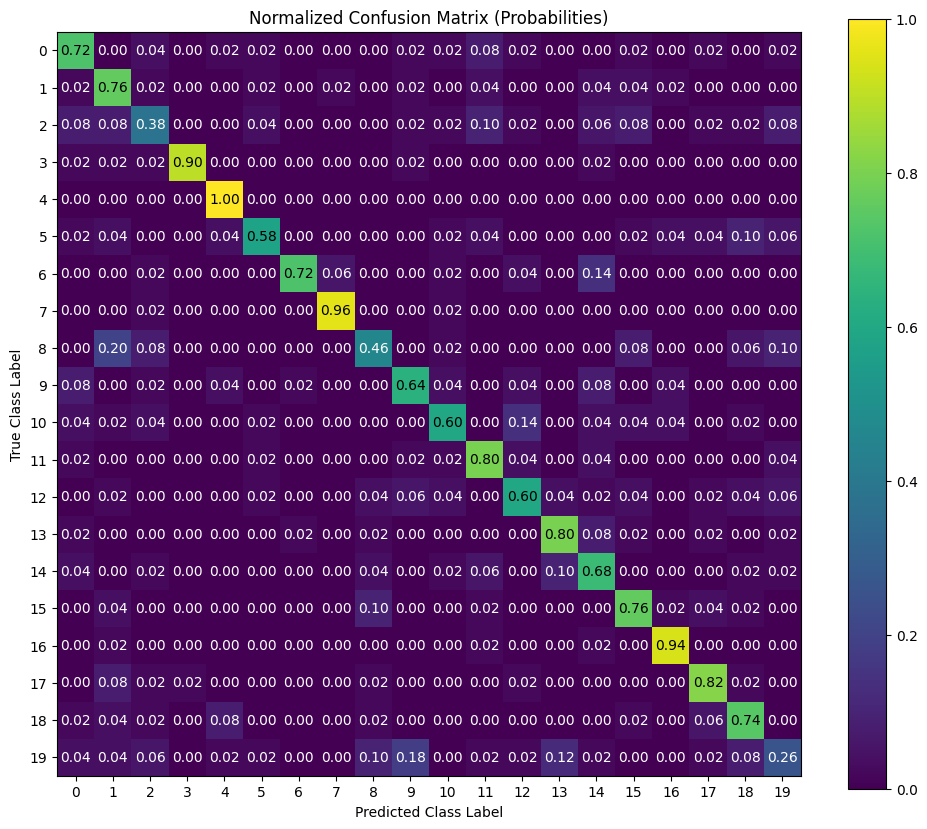

In [30]:
rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
rf_confusion_matrix_normalized = rf_confusion_matrix.astype('float') / rf_confusion_matrix.sum(axis=1)[:, np.newaxis]

A_i = rf_confusion_matrix_normalized.diagonal()
A = np.mean(A_i)
print(f"\nPer-class accuracies (Ai): {A_i}")
print(f"Average accuracy (A) from normalized confusion matrix diagonal: {A * 100:.2f}%")

fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(rf_confusion_matrix_normalized, cmap="viridis", interpolation='nearest')

fig.colorbar(cax)

num_classes = rf_confusion_matrix_normalized.shape[0]
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels([str(i) for i in range(num_classes)]) 
ax.set_yticklabels([str(i) for i in range(num_classes)]) 

plt.xlabel("Predicted Class Label")
plt.ylabel("True Class Label")
plt.title("Normalized Confusion Matrix (Probabilities)")

for i in range(num_classes):
    for j in range(num_classes):
        text_color = "white" if rf_confusion_matrix_normalized[i, j] < (rf_confusion_matrix_normalized.max() / 2.) else "black"
        ax.text(j, i, f"{rf_confusion_matrix_normalized[i, j]:.2f}",
                ha="center", va="center", color=text_color)

plt.show()

In [ ]:
num_test_samples_per_class = 50
image_indices = []
for class_idx in range(num_classes):
    start_image_idx_for_class = (class_idx * 100) + 50
    for i in range(num_test_samples_per_class):
        image_indices.append(start_image_idx_for_class + i)

y_test_output = y_test + 1
y_pred_rf_output = y_pred_rf + 1

results_df = pd.DataFrame({
    'id': image_indices[:len(y_test)],
    'true_label': y_test_output,
    'predicted_label': y_pred_rf_output
})

output_csv_path = "prediction_results.csv"
results_df.to_csv(output_csv_path, index=False)